# **Classification Algorithms** 

The experiments conducted using different feature selections methods such as PCA, Correlation, RandomForest based feature selections and the last was without feature selection. Experiment algorithms are as follows:

- SVM (Support Vector Machine) 
- Gaussian Naive Bayes
- Multinomial Naive Bayes 
- Bernoulli Naive Bayes
- Gradient Boost Tree 
- Cat Boost Tree 
- XGBoost Tree 
- K-Nearest Neighbors

In [1]:
!pip install catboost

     |████████████████████████████████| 65.8 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.9 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.5 MB 2.3 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=ab4e93bba83b1bdb7b0bb8099bfa2024f62c37db08bea255b0c33d46092ca4ba
  Stored in directory: /home/asus/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: pandas
    Found existing installation: pandas 0.23.4
    Uninstalling pandas-0.23.4:
      Successfully uninstalled pandas-0.23.4


In [7]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler, Normalizer, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.decomposition import PCA
import timeit
from warnings import filterwarnings
filterwarnings('ignore')

In [9]:
def crosstab(index, col, normalize="columns"):
    return pd.crosstab(index, col, normalize=normalize)

def correlation_df(data, remove_columns=None):
    if(remove_columns is None):
        corr = data.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    else:
        data2 = data.drop(remove_columns, axis=1)
        corr = data2.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    return new_df

def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

def sortDifferentCategory(data):
    def takeSecond(elem):
        return elem[1]

    listem = []
    for i in data.select_dtypes(include=["object", "int64", "float64"]).columns:
        listem.append([i, data[i].value_counts().count()])

    return sorted(listem, key=takeSecond ,reverse=False)


In [12]:
def layer1(data_norm, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data_norm.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df

def featureselection_pca(data_minmax, target, threshold):
    x = data_minmax.drop([target], axis=1)
    y = data_minmax[target]
    pca = PCA()    
    X_pca = pca.fit_transform(x)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = x.index)
    X_pcad[target] = y
    return X_pcad

def layer2(new_df, target, num_feats):
    x = new_df.drop([target], axis=1)
    y = new_df[target]
    cor_list = []
    feature_name = list(x.columns)
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    return cor_feature

def featureselection_randomforest(xtrain,ytrain, params, top_feat, cv=10, n_jobs=-1, verbose=2):
    model = RandomForestClassifier()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.max_features = grid_cv_model.best_params_["max_features"] 
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.min_samples_split= grid_cv_model.best_params_["min_samples_split"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    #y_pred = model_tuned.predict(xtest)
    
    importance = pd.DataFrame({"importance": model.feature_importances_*100}, index = xtrain.columns)
    rf_columns = importance.sort_values(by="importance", axis=0, ascending=False).head(top_feat).index
    new_df = xtrain[rf_columns]
    new_df["bad"] = ytrain
    return new_df

def featureselection_corrcorr(data, target, threshold, num_feat):
    layer1_df = layer1(data, target, threshold)
    last_features = layer2(layer1_df, target, num_feat)
    reduced_df = data[last_features]
    reduced_df[target] = data[target]
    return reduced_df

def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [13]:
def describe(data):
    desc_df = data.describe().T
    null_count = data.isnull().sum()
    null_percent = (data.isnull().sum() / data.count())*100
    variance = data.var()

    desc_df["variance"] =  round(variance,3)
    desc_df["null_values"] = round(null_count,3)
    desc_df["null__rate"] = round(null_percent,3)
    return desc_df.T

def normalization_minmax(dataframe):
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(dataframe)
    array = scaler.transform(dataframe)
    data_minmax = pd.DataFrame(array, columns=dataframe.columns)
    return data_minmax

def nulldata_check(data):
    count = data.isnull().sum().sort_values(ascending=True).to_frame()
    percent = (data.isnull().sum().sort_values(ascending=True)/data["bad"].count()).to_frame().round(decimals=4)
    df = pd.concat([count, percent], axis=1)
    df.columns = ["count","percentage"]
    return df

def evaluation_metrics(ytest, y_pred):
    print("accuracy : ", round(accuracy_score(ytest,y_pred),5),
      "\nprecision: ", round(precision_score(ytest,y_pred),5),
      "\nrecall   : ", round(recall_score(ytest,y_pred),5),
      "\nf1-score : ", round(f1_score(ytest,y_pred),5))
    
def train_test_splitting(data, target, test_size=0.25, random_state=42):
    x = data.drop([target], axis=1)
    y = data[target]
    xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=test_size, random_state=random_state)
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
    return xtrain, xtest, ytrain, ytest

# **1. Data Exploration**

### **1.1.  Veri Degiskenlerinin Aciklanmasi**

**BAD:** BAD değişkeni veri setinde hedef değişkenidir. **'1'** kişinin borcunu zamanında ve usulüne göre yerine getirmediği durum. **'0'** kredi borcunu zamanında ödemiş. 

**LOAN:** Bankadan talep ettiği kredi miktarı 

**MORTDUE:** İpotek için ödemesi gereken tutar

**VALUE:** Müşterinin geçerli mülk değeri

**REASON:** **DebtCont=** diğer borç yükümlülükleri için alınan borç. **HomeImp=** Kişisel ev ihtiyaçları için alınan borç 

**JOB:** Müşterinin meslek (kategorik veri)

**YOJ:** Mevcut mesleğinde kaç yıldır çalışıyor

**DEROG:** Kredi almasını etkileyen önemli zararlı/uygunsuz rapor sayısı

**DELINQ:** Zamanında ödenmemiş kredi sayısı

**CLAGE:** Aylar içinde en eski kredi limitinin yaşı

**NINQ:** Kredi ile ilgili son yapılan sorgu sayısı

**CLNO:** Kredi limitinin sayısı 

**DEBTINC:** Müşterinin borç-gelir oranı 

In [15]:
data = pd.read_csv("hmelq.csv")
data.head()

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,0,81200,18834.0,108355.0,HomeImp,NaN,28.0,0.0,0.0,139.14,0.0,14.0,34.042
1,0,12600,103960.0,127384.0,DebtCon,NaN,2.0,0.0,0.0,129.02,0.0,25.0,34.479
2,0,18000,46865.0,61266.0,DebtCon,NaN,5.0,0.0,0.0,102.59,2.0,9.0,26.354
3,0,10300,57676.0,71027.0,DebtCon,NaN,19.0,0.0,0.0,157.52,1.0,11.0,33.992
4,0,9400,56508.0,78358.0,DebtCon,NaN,17.0,0.0,0.0,141.93,0.0,11.0,32.327


### **1.2. Verilerin Istatistiksel Dagilimi**

In [16]:
print("Shape: ", data.shape)
describe(data).T

Shape:  (3576, 13)


,count,mean,std,min,25%,50%,75%,max,variance,null_values,null__rate
bad,3576.0,0.199385,0.399594,0.00,0.00,0.000,0.00,1.000,1.600000e-01,0.0,0.000
loan,3576.0,18529.697987,11262.834060,1100.00,11000.00,16200.000,23100.00,89900.000,1.268514e+08,0.0,0.000
mortdue,3262.0,74013.907992,44016.833772,2619.00,46700.25,65858.000,91717.00,399550.000,1.937482e+09,314.0,9.626
value,3512.0,101076.922759,54865.275351,8800.00,65753.00,89183.000,118928.25,850000.000,3.010198e+09,64.0,1.822
yoj,3264.0,8.832644,7.568046,0.00,3.00,7.000,13.00,41.000,5.727500e+01,312.0,9.559
derog,3149.0,0.261670,0.865178,0.00,0.00,0.000,0.00,10.000,7.490000e-01,427.0,13.560
delinq,3225.0,0.432558,1.099230,0.00,0.00,0.000,0.00,15.000,1.208000e+00,351.0,10.884
clage,3397.0,179.832529,87.066198,0.49,115.60,173.640,230.71,1168.230,7.580523e+03,179.0,5.269
ninq,3273.0,1.186373,1.728723,0.00,0.00,1.000,2.00,17.000,2.988000e+00,303.0,9.258
clno,3443.0,21.507116,10.167490,0.00,15.00,20.000,26.00,71.000,1.033780e+02,133.0,3.863


### **1.3. Kategorik-Numerik Degiskenlerin Incelenmesi**

In [17]:
num, cat = numeric_categoric_variable(data)
print("\n")
for i in data.select_dtypes(include=["object"]).columns:
    print(i,": ",data[i].value_counts().count())

Numeric Column  :
 ['bad', 'loan', 'mortdue', 'value', 'yoj', 'derog', 'delinq', 'clage', 'ninq', 'clno', 'debtinc'] 

Categoric Column :
 ['reason', 'job']


reason :  2
job :  6


Burada degiskenlerde kac farkli kategori oldugunu kontrol ediyoruz. Daha onceden kategorik veriler sayisal olarak girilmis olabilir. Ancak degiskenleri inceledigimize job ve reason disinda kategorik degiskenlerin olmadigini goruyoruz. derog ve delinq degiskenlerini dusunduk ancak odenmemis kredi sayisi ve uygunsun rapor sayisi oldugundan ayrik sayisal degerler oldugunu goruyoruz.

In [18]:
sortDifferentCategory(data)

[['bad', 2],
 ['reason', 2],
 ['job', 6],
 ['derog', 11],
 ['delinq', 12],
 ['ninq', 15],
 ['clno', 61],
 ['yoj', 86],
 ['loan', 474],
 ['debtinc', 2653],
 ['clage', 3050],
 ['mortdue', 3095],
 ['value', 3302]]

### **1.4. Categoric Variables using CrossTab**

In [19]:
bad_class = pd.crosstab(index=data["bad"], columns=data["job"], normalize="columns")
bad_class

job,Mgr,Office,Other,ProfEx,Sales,Self
bad,,,,,,
0,0.767896,0.86819,0.767994,0.833116,0.651515,0.704348
1,0.232104,0.13181,0.232006,0.166884,0.348485,0.295652


In [20]:
crosstab([data["bad"], data["reason"]], data["job"], "index")

job               Mgr    Office     Other    ProfEx     Sales      Self
bad reason                                                             
0   DebtCon  0.147216  0.172377  0.414347  0.229657  0.021413  0.014989
    HomeImp  0.088348  0.203585  0.379001  0.257362  0.003841  0.067862
1   DebtCon  0.154378  0.129032  0.460829  0.170507  0.046083  0.039171
    HomeImp  0.144033  0.078189  0.518519  0.193416  0.012346  0.053498

Burada kredisini odeyen ve odemeyen incelendi ve Karar agaclarinin daha kolay islem yapabilmesi icin ikiye ayrildi. 0-2 arasi odenmemis kredisi olanlar borcunu %79 oraninda oduyor ve bu nedenle 0-2 ve 3-10 arasi seklinde ayiriyoruz. Veya Yuksek-Orta-Hic seklindede ayirabiliriz.

In [21]:
crosstab(data["bad"], data["delinq"], "columns")

delinq,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,13.0,15.0
bad,,,,,,,,,,,,
0,0.858959,0.648241,0.598592,0.391304,0.392157,0.190476,0.0,0.0,0.0,0.0,0.0,0.0
1,0.141041,0.351759,0.401408,0.608696,0.607843,0.809524,1.0,1.0,1.0,1.0,1.0,1.0


Toplam verisetinde %5'ten kucuk null degerine value, clno, reason, job degiskenleri oldugunu goruyoruz. Veri karakteristigini daha az etkileyecegini dusundugumuz bu %5lik degiskenleri median ile doldurmayi dusunduk.

### **1.5. NULL Values Checking**

In [22]:
null_data = nulldata_check(data)
null_data[null_data["percentage"] <= 0.55]

,count,percentage
bad,0,0.0000
loan,0,0.0000
value,64,0.0179
clno,133,0.0372
reason,147,0.0411
job,167,0.0467
clage,179,0.0501
ninq,303,0.0847
yoj,312,0.0872
mortdue,314,0.0878


# **2. Data Visualization**

### **2.1. Correlation HeatMap**

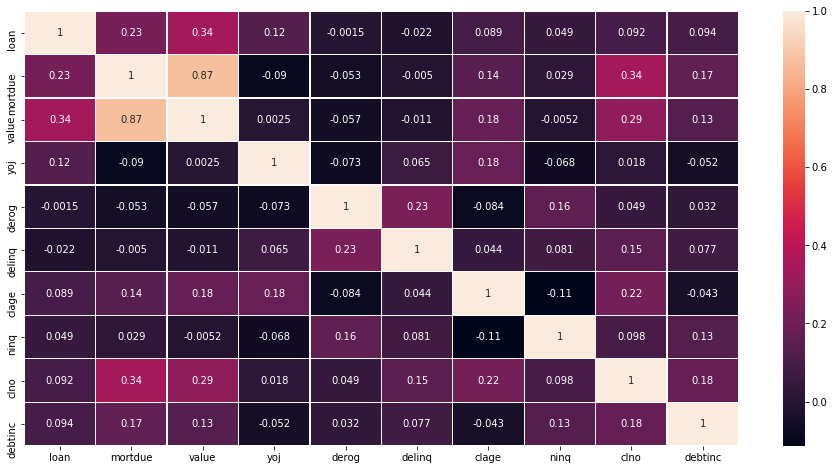

In [23]:
def heatmap(data, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)   
    sns.heatmap(data.corr(), annot=True, linewidths=.3, ax=ax)
    plt.show()

heatmap(data.drop(["bad"],axis=1))

Value ve mortdue incelendiğinnde 0.87 korelasyona sahip oldukları görülmektedir. Biri artarken diğerininde arttığı görülmektedir. Mal varlığı yüksek olan birisi ipoteğide fazla verip kredi skorunu etkileyebilir.

In [24]:
print("Most Correlated\n",correlation_df(data.drop(["bad"],axis=1)).sort_values(by="Corr", ascending=False).head(5),"\n")
print("Less Correlated\n",correlation_df(data.drop(["bad"],axis=1)).sort_values(by="Corr", ascending=True).head(5),"\n")

Most Correlated
    feature1 feature2      Corr
11  mortdue    value  0.873280
17  mortdue     clno  0.340139
2      loan    value  0.337453
25    value     clno  0.290439
35    derog   delinq  0.234706 

Less Correlated
    feature1 feature2      Corr
4      loan    derog  0.001463
20    value      yoj  0.002501
14  mortdue   delinq  0.004971
24    value     ninq  0.005191
22    value   delinq  0.011014 



### **2.2. Scatter Plot**

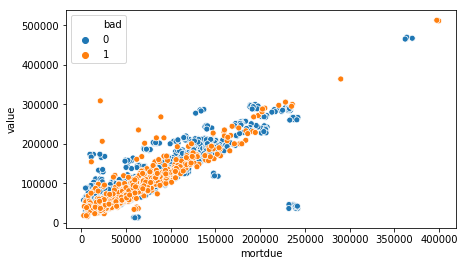

In [25]:
def scatterplot(x,y, hue, data, figsize=(7,4)):
    fig, ax = plt.subplots(figsize=figsize)        
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.show()

scatterplot("mortdue", "value", "bad", data)

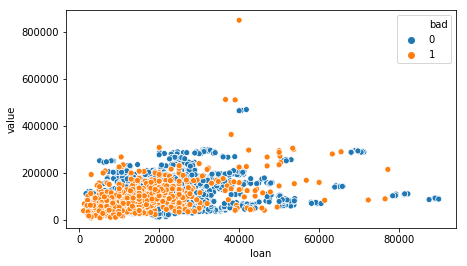

In [26]:
scatterplot("loan", "value", "bad", data)

Boxplot grafigi incelendiginde ise **loan, mortdue ve value** degiskenlerinde aykiri degerler oldugunu goruyoruz. Orjinal verileri manipule edip silmek istemedigimizden, verilere normalizasyon yontemini uyguluyoruz.

### **2.3. Box Plot**

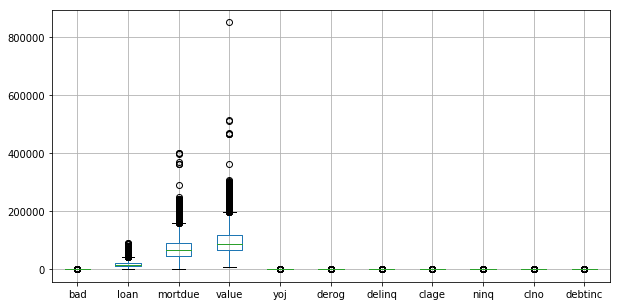

In [27]:
def boxplot(boxplot_df, figsize=(10,5)):
    plt.figure(figsize=figsize)
    boxplot_df.boxplot()
    plt.show()

boxplot(data)

Histogram grafigi incelendiginde ise verilerin kesikli ve normal dagilimdan gelmedigini goruyoruz. Modelimizin daha iyi sonuc vermesi icin normalizasyon yontemlerinin uygulanmasi gerektigini uygun goruyoruz.

### **2.4. Histogram**

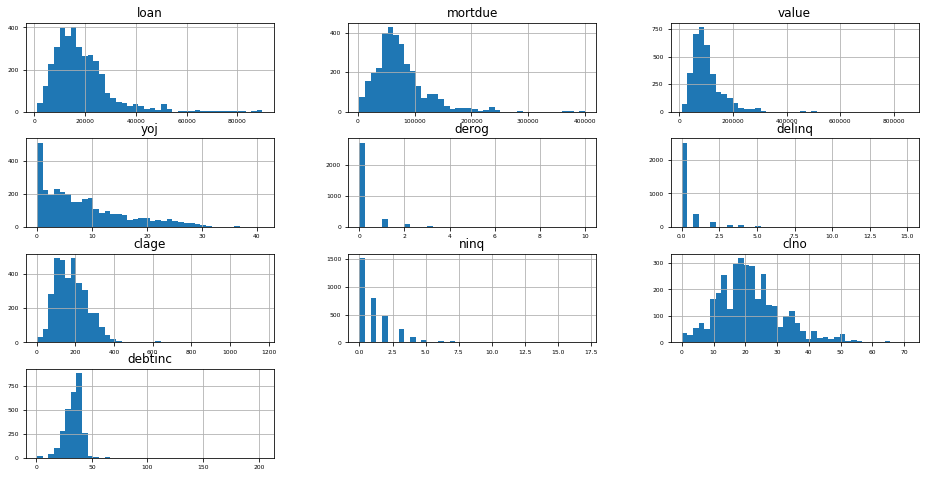

In [28]:
def histogram(datas, bins=40, xlabelsize=6, ylabelsize=6, figsize=(10,5)):
    datas.hist(figsize=figsize, bins=bins, xlabelsize=xlabelsize, ylabelsize=ylabelsize)
    plt.show()
    
histogram(data.drop(["bad"],axis=1), figsize=(16,8))

# **3. Data Preprocessing**

### **3.1. Data Imputation**
- value 
- clno
- reason
- job

Ancak dropna yaptigimizda datanin %45'sini silmis bulunuyoruz. Bu nedenle bazi degiskenleri silemk istmiyoruz. Imputation yontemine gidiyoruz. Burada %5'ten kucuk NULL oranina sahip degerleri median ile ve Unknown kategori ile dolduruyoruz.

#### **With Imputation**

In [29]:
imputation_df = data.copy()
imputation_df["value"] = data["value"].fillna(data["value"].median())
imputation_df["clno"] = data["clno"].fillna(data["clno"].median())
imputation_df["reason"] = data["reason"].fillna("Unknown")
imputation_df["job"] = data["job"].fillna("Unknown")
print(imputation_df.count())

bad        3576
loan       3576
mortdue    3262
value      3576
reason     3576
job        3576
yoj        3264
derog      3149
delinq     3225
clage      3397
ninq       3273
clno       3576
debtinc    2809
dtype: int64


#### **Without Imputation**

In [30]:
without_imputation_df = data.copy()
without_imputation_df.dropna(inplace=True)
print("Total Row: ",without_imputation_df.count()["bad"])
nulldata_check(without_imputation_df)

Total Row:  2018


,count,percentage
bad,0,0.0
loan,0,0.0
mortdue,0,0.0
value,0,0.0
reason,0,0.0
job,0,0.0
yoj,0,0.0
derog,0,0.0
delinq,0,0.0
clage,0,0.0


### **3.2. NULL Data Drop**

In [31]:
imputation_df.dropna(inplace=True)
print("Total Row: ",imputation_df.count()["bad"])
nulldata_check(imputation_df)

Total Row:  2114


,count,percentage
bad,0,0.0
loan,0,0.0
mortdue,0,0.0
value,0,0.0
reason,0,0.0
job,0,0.0
yoj,0,0.0
derog,0,0.0
delinq,0,0.0
clage,0,0.0


### **3.3. Numeric to Categoric Tranformation**

### --> Without imputation

In [32]:
imputation_df = without_imputation_df
imputation_df.head(3)

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
153,0,18200,94727.0,136877.0,DebtCon,Mgr,15.0,0.0,0.0,168.96,2.0,26.0,36.056
154,0,21700,79240.0,96784.0,DebtCon,Mgr,5.0,0.0,0.0,64.51,6.0,24.0,38.079
155,0,34100,241931.0,36486.0,DebtCon,Mgr,1.0,0.0,2.0,196.01,3.0,50.0,42.459


Burada degiskenleri bad hedef degiskenine gore crosstab ile analiz edip, kategori incelemesi gereceklestiriyoruz. Numerik olan degiskenlerin kateogrik olacak sekilde araliklarini belirliyoruz. 

#### **3.3.1 DEROG Degiskeni**

DEROG - Kredi borcunu zamaninda odemesi bakimindan musteri hakkinda zararli rapor sayisini inceledigimizde 0-2 arasinda zararli rapor sayisina sahip olan musteriler borclarini %77.5-92.5 arasinda odedigi goruluyor. Bu nedenle bunu uc kategoriye ayiriyoruz. 

- **RaporYok (0)**: 0 raporu olanlar genellikle %92 oraninda borcunu geri odemektedir. 
- **DusukRapor  (1-2)**: 1-2 arasinda zararli rapora sahip olanlar borcunu yuksek oranda odedigi gorulmektedir.
- **YuksekRapor (3-10)**: 3-10 arasinda zararli rapora sahip olanlar borcunu ortalamadan dusuk veya hic odemedigi goruluyor. Ancak bu kategoride elimizde yeterli (unbalanced) veri bulunmaktadir.rclarini geri oduyorlarmis. 

In [33]:
crosstab(imputation_df["bad"], imputation_df["derog"])

derog,0.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,10.0
bad,,,,,,,,,
0,0.927043,0.835938,0.791667,0.416667,0.0,0.0,0.0,0.0,0.0
1,0.072957,0.164062,0.208333,0.583333,1.0,1.0,1.0,1.0,1.0


In [34]:
derog_replace = {0: "RaporYok", 1: "DusukRapor", 2: "DusukRapor", 3: "YuksekRapor", 4: "YuksekRapor",
                 4: "YuksekRapor",6: "YuksekRapor",7: "YuksekRapor",8: "YuksekRapor", 9: "YuksekRapor",
                10: "YuksekRapor"}
imputation_df = imputation_df.replace({"derog": derog_replace})

#### **3.3.2. DELINQ Degiskeni**

DELINQ - Zamaninda odenmemis kredi sayisi bakimindan cogunlugunu 0,1,2 ve 3 odenmemis kredi sayisina sahip musterler olusturdugunu goruyoruz. Musterinin borcunu geri odemesi bakimindan 3'den fazla odenmemis odenmemis kredisi olanlari yuksek odenmemis kredi olarak isaretliyoruz. 

- **GecikmeYok (0)**: Sifir gecikme sayisina sahip olanlar borcunu %93.2 oraninda geri odemektedir. 
- **DusukGecikme (1-3)**: 1-3 arasi dusuk sayida gecikmis kredi sayisina sahip olan musteriler %72-86.5 arasinda borcunu odemektedir.  
- **YuksekGecikme (4-10)**: 4-10 arasi yuksek sayida gecikmis kredi sayisina sahip olan musteriler ise %0-50 arasinda borcunu geri odedigi gorulmektedir. Ancak 4'ten fazla gecikme sayisi olan musterilerin buyuk oranda borcunu hic odemedigi gorulmektedir.

In [35]:
crosstab(imputation_df["bad"], imputation_df["delinq"])

delinq,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,10.0
bad,,,,,,,,,
0,0.933294,0.871658,0.791667,0.72,0.538462,0.0,0.0,0.0,0.0
1,0.066706,0.128342,0.208333,0.28,0.461538,1.0,1.0,1.0,1.0


In [36]:
delinq_replace = {0: "GecikmeYok", 1: "DusukGecikme", 2: "DusukGecikme", 3: "DusukGecikme", 
                 4: "YuksekGecikme", 4: "YuksekGecikme",5: "YuksekGecikme",6: "YuksekGecikme",
                 7: "YuksekGecikme",8: "YuksekGecikme", 9: "YuksekGecikme", 10: "YuksekGecikme"}
imputation_df = imputation_df.replace({"delinq": delinq_replace})

#### **3.3.3. NINQ Degiskeni**

NINQ - Kredi ile ilgili yapilan sorgu sayisi bakimindan incelendiginde, verinin cogunlugunu 0,1,2 ve 3 sorgu degerine sahip musteriler olusturmaktadir. Degiskeni kategorik hale getirmek icin musterilerin en az %70 oraninda borcunu geri odemesi ve hakkinda en fazla 4 kredi sorgu yapilmis olmasi varsayimlarini kabul ediyoruz. Kredi ile ilgili 0 hic sorgusu olmayan 1-3 arasi sorgu yapildiysa DusukSorgu, 4'ten fazla sorgularda ise YuksekSorgu olarak isaretliyoruz. 

- **SorguYok (0):** Sifir kredi sorgusu olan musterilerin kredisini %91.72 oraninda odedigi gorulmektedir.
- **DusukSorgu (1-4):** Kredi ile ilgili sorgu sayisi 1-4 arasi olanlar kredilerini %74.41-93.01 oaraninda zamaninda odedigi gorulmektedir. 
- **YuksekSorgu (5-13):** 4-13 sroguya sahip olanlar genellikle %74'ten az oranda borclarini geri oduyorlarmis. 

In [37]:
crosstab(imputation_df["bad"], imputation_df["ninq"])

ninq,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,13.0
bad,,,,,,,,,,,,,
0,0.920118,0.933333,0.92446,0.885714,0.75,0.6,0.642857,0.727273,1.0,0.666667,0.9,1.0,0.0
1,0.079882,0.066667,0.07554,0.114286,0.25,0.4,0.357143,0.272727,0.0,0.333333,0.1,0.0,1.0


In [38]:
ninq_replace = {0: "SorguYok", 1: "DusukSorgu", 2: "DusukSorgu", 3: "DusukSorgu", 
                 4: "DusukSorgu", 4: "YuksekSorgu",5: "YuksekSorgu",6: "YuksekSorgu", 7: "YuksekSorgu",
                 8: "YuksekSorgu", 9: "YuksekSorgu", 10: "YuksekSorgu", 11:"YuksekSorgu",
                12:"YuksekSorgu", 13:"YuksekSorgu" }
imputation_df = imputation_df.replace({"ninq": ninq_replace})

#### **3.3.4. YOJ Degiskeni**

YOJ - Musterilerin mevcut is yerinde calistigi yil bakimindan incelendiginde, 0-10 yil arasinda musterilerin her yilda 100'den fazla musteri oldugunu goruyoruz. Bu nedenle musterileri mevcut is yili bakiminda 0-10, 11-20, 21-30, 31-40, 41-50 seklinde kategorilere ayiriyoruz. 

In [39]:
crosstab(imputation_df["bad"], imputation_df["yoj"])

yoj,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,25.0,26.0,27.0,28.0,29.0,30.0,31.0,35.0,36.0,41.0
bad,,,,,,,,,,,,,,,,,,,,,
0,0.909605,0.927007,0.872,0.843478,0.921053,0.871795,0.928571,0.934783,0.895349,0.920354,...,0.909091,0.909091,0.947368,0.916667,1.0,0.875,1.0,1.0,1.0,0.0
1,0.090395,0.072993,0.128,0.156522,0.078947,0.128205,0.071429,0.065217,0.104651,0.079646,...,0.090909,0.090909,0.052632,0.083333,0.0,0.125,0.0,0.0,0.0,1.0


In [40]:
yoj = []
for i in imputation_df["yoj"]:
    i = int(i)
    if(i >= 0 and i<=10):
        yoj.append("0-10")
    elif(i>10 and i<=20):
        yoj.append("11-20")
    elif(i>20 and i<=30):
        yoj.append("21-30")
    elif(i>30 and i<=40):
        yoj.append("31-40")
    else:
        yoj.append("41-50")

imputation_df["yoj"] = yoj

In [41]:
imputation_df.head()

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
153,0,18200,94727.0,136877.0,DebtCon,Mgr,11-20,RaporYok,GecikmeYok,168.96,DusukSorgu,26.0,36.056
154,0,21700,79240.0,96784.0,DebtCon,Mgr,0-10,RaporYok,GecikmeYok,64.51,YuksekSorgu,24.0,38.079
155,0,34100,241931.0,36486.0,DebtCon,Mgr,0-10,RaporYok,DusukGecikme,196.01,DusukSorgu,50.0,42.459
156,0,8400,62989.0,76718.0,HomeImp,Mgr,0-10,RaporYok,DusukGecikme,131.47,SorguYok,22.0,29.200
157,0,17400,25859.0,43684.0,DebtCon,Mgr,11-20,DusukRapor,GecikmeYok,95.36,DusukSorgu,17.0,27.108


### **3.4. Dummy Transformation**

In [42]:
num, category = numeric_categoric_variable(imputation_df)

Numeric Column  :
 ['bad', 'loan', 'mortdue', 'value', 'clage', 'clno', 'debtinc'] 

Categoric Column :
 ['reason', 'job', 'yoj', 'derog', 'delinq', 'ninq']


In [43]:
data_dummy = dummy_df(imputation_df, category)
num, cat = numeric_categoric_variable(data_dummy)
data_dummy.head(3)

Numeric Column  :
 ['bad', 'loan', 'mortdue', 'value', 'clage', 'clno', 'debtinc', 'reason_DebtCon', 'reason_HomeImp', 'job_Mgr', 'job_Office', 'job_Other', 'job_ProfEx', 'job_Sales', 'job_Self', 'yoj_0-10', 'yoj_11-20', 'yoj_21-30', 'yoj_31-40', 'yoj_41-50', 'derog_DusukRapor', 'derog_RaporYok', 'derog_YuksekRapor', 'delinq_DusukGecikme', 'delinq_GecikmeYok', 'delinq_YuksekGecikme', 'ninq_DusukSorgu', 'ninq_SorguYok', 'ninq_YuksekSorgu'] 

Categoric Column :
 []


,bad,loan,mortdue,value,clage,clno,debtinc,reason_DebtCon,reason_HomeImp,job_Mgr,...,yoj_41-50,derog_DusukRapor,derog_RaporYok,derog_YuksekRapor,delinq_DusukGecikme,delinq_GecikmeYok,delinq_YuksekGecikme,ninq_DusukSorgu,ninq_SorguYok,ninq_YuksekSorgu
153,0,18200,94727.0,136877.0,168.96,26.0,36.056,1,0,1,...,0,0,1,0,0,1,0,1,0,0
154,0,21700,79240.0,96784.0,64.51,24.0,38.079,1,0,1,...,0,0,1,0,0,1,0,0,0,1
155,0,34100,241931.0,36486.0,196.01,50.0,42.459,1,0,1,...,0,0,1,0,1,0,0,1,0,0


### **3.5. Normalization**

In [44]:
data_minmax = normalization_minmax(data_dummy)
data_minmax.head(3)

,bad,loan,mortdue,value,clage,clno,debtinc,reason_DebtCon,reason_HomeImp,job_Mgr,...,yoj_41-50,derog_DusukRapor,derog_RaporYok,derog_YuksekRapor,delinq_DusukGecikme,delinq_GecikmeYok,delinq_YuksekGecikme,ninq_DusukSorgu,ninq_SorguYok,ninq_YuksekSorgu
0,0.0,0.187075,0.227347,0.232520,0.144270,0.40625,0.228498,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.226757,0.188073,0.150633,0.054824,0.37500,0.242931,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.367347,0.600643,0.027481,0.167435,0.78125,0.274181,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# **4. Feature Selection**

### 4.1. Principal Component Analysis

In [45]:
data_pca = featureselection_pca(data_minmax,"bad", 0.9)
data_pca.head()

pca sonrası değişken sayısı:  9


,0,1,2,3,4,5,6,7,8,bad
0,-0.731283,-0.503780,0.859174,0.650631,-0.230217,0.336906,0.511953,-0.650730,-0.049518,0.0
1,-0.365154,-0.203467,-0.512842,0.168786,-0.002665,0.367648,0.721640,-0.703201,0.123162,0.0
2,-0.856140,0.139723,-0.027679,0.261835,1.261572,0.133774,0.076385,-0.982768,0.260247,0.0
3,1.052660,0.648982,-0.011003,-0.076870,1.172337,0.263991,0.259323,-1.009152,0.149988,0.0
4,-0.835913,-0.429815,0.870792,0.478768,0.175907,0.128854,1.512593,0.165357,-0.179672,0.0


### 4.2. Correlation based Feature Selection

In [46]:
data_corr = featureselection_corrcorr(data_minmax, "bad",0.6, 10)
data_corr.head()

,yoj_41-50,clage,derog_DusukRapor,delinq_DusukGecikme,ninq_YuksekSorgu,derog_RaporYok,delinq_GecikmeYok,derog_YuksekRapor,delinq_YuksekGecikme,debtinc,bad
0,0.0,0.144270,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.228498,0.0
1,0.0,0.054824,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.242931,0.0
2,0.0,0.167435,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.274181,0.0
3,0.0,0.112165,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.179582,0.0
4,0.0,0.081242,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.164656,0.0


### 4.3. RandomForest based Feature Selection

In [47]:
rf_params = {"max_depth": [2,5,8,10],
             "max_features": [4,5,6,7],
             "n_estimators": [10,50,100],
             "min_samples_split": [5,10]}

x= data_minmax.drop(["bad"], axis=1)
y = data_minmax["bad"]

data_rf = featureselection_randomforest(x,y, rf_params, 7) 
data_rf.head()

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   19.1s finished


,debtinc,loan,value,clage,clno,mortdue,delinq_YuksekGecikme,bad
0,0.228498,0.187075,0.232520,0.144270,0.406250,0.227347,0.0,0.0
1,0.242931,0.226757,0.150633,0.054824,0.375000,0.188073,0.0,0.0
2,0.274181,0.367347,0.027481,0.167435,0.781250,0.600643,0.0,0.0
3,0.179582,0.075964,0.109651,0.112165,0.343750,0.146862,0.0,0.0
4,0.164656,0.178005,0.042182,0.081242,0.265625,0.052704,0.0,0.0


# **5. Modelling (Algorithms)**

- SVM (Support Vector Machine)
- Naive Bayes (Gaussian Naive Bayes)
- Naive Bayes (Multinomial Naive Bayes)
- Naive Bayes (Bernoulli Naive Bayes)
- Gradient Boosted Tree
- Cat Boost Tree
- XGBoost Tree
- K-Nearest Neighbors

## 5.1. SVM (Support Vector Machine)

### 5.1.1. PCA based FS

In [48]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "bad")
svm = SVC(kernel="linear")
smv_model = svm.fit(xtrain, ytrain)
y_pred = smv_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 9) (505, 9) (1513,) (505,)
accuracy :  0.92277 
precision:  0.0 
recall   :  0.0 
f1-score :  0.0

               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       466
         1.0       0.00      0.00      0.00        39

   micro avg       0.92      0.92      0.92       505
   macro avg       0.46      0.50      0.48       505
weighted avg       0.85      0.92      0.89       505



### 5.1.2. Correlation based FS

In [49]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")
svm = SVC(kernel="linear")
smv_model = svm.fit(xtrain, ytrain)
y_pred = smv_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 10) (505, 10) (1513,) (505,)
accuracy :  0.92277 
precision:  0.5 
recall   :  0.15385 
f1-score :  0.23529

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.50      0.15      0.24        39

   micro avg       0.92      0.92      0.92       505
   macro avg       0.72      0.57      0.60       505
weighted avg       0.90      0.92      0.90       505



### 5.1.3. RandomForest based FS

In [95]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
svm = SVC(kernel="linear")
smv_model = svm.fit(xtrain, ytrain)
y_pred = smv_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 7) (505, 7) (1513,) (505,)
accuracy :  0.91881 
precision:  0.33333 
recall   :  0.05128 
f1-score :  0.08889

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.33      0.05      0.09        39

   micro avg       0.92      0.92      0.92       505
   macro avg       0.63      0.52      0.52       505
weighted avg       0.88      0.92      0.89       505



### 5.1.4. Without Feature Selection

In [51]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "bad")
svm = SVC(kernel="linear")
smv_model = svm.fit(xtrain, ytrain)
y_pred = smv_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 28) (505, 28) (1513,) (505,)
accuracy :  0.92277 
precision:  0.5 
recall   :  0.15385 
f1-score :  0.23529

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.50      0.15      0.24        39

   micro avg       0.92      0.92      0.92       505
   macro avg       0.72      0.57      0.60       505
weighted avg       0.90      0.92      0.90       505



## 5.2. Naive Bayes (Gaussian Naive Bayes)

### 5.2.1. PCA based FS

In [52]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "bad")
gnb = GaussianNB()
gnb_model = gnb.fit(xtrain, ytrain)
y_pred = gnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 9) (505, 9) (1513,) (505,)
accuracy :  0.89901 
precision:  0.22727 
recall   :  0.12821 
f1-score :  0.16393

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       466
         1.0       0.23      0.13      0.16        39

   micro avg       0.90      0.90      0.90       505
   macro avg       0.58      0.55      0.56       505
weighted avg       0.88      0.90      0.89       505



### 5.2.2. Correlation based FS

In [53]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")
gnb = GaussianNB()
gnb_model = gnb.fit(xtrain, ytrain)
pred = gnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 10) (505, 10) (1513,) (505,)
accuracy :  0.89901 
precision:  0.22727 
recall   :  0.12821 
f1-score :  0.16393

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       466
         1.0       0.23      0.13      0.16        39

   micro avg       0.90      0.90      0.90       505
   macro avg       0.58      0.55      0.56       505
weighted avg       0.88      0.90      0.89       505



### 5.2.3. RandomForest based FS

In [92]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
gnb = GaussianNB()
gnb_model = gnb.fit(xtrain, ytrain)
pred = gnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 7) (505, 7) (1513,) (505,)
accuracy :  0.92871 
precision:  0.8 
recall   :  0.10256 
f1-score :  0.18182

               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       466
         1.0       0.80      0.10      0.18        39

   micro avg       0.93      0.93      0.93       505
   macro avg       0.86      0.55      0.57       505
weighted avg       0.92      0.93      0.90       505



### 5.2.4. Without Feature Selection

In [55]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "bad")
gnb = GaussianNB()
gnb_model = gnb.fit(xtrain, ytrain)
pred = gnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 28) (505, 28) (1513,) (505,)
accuracy :  0.89901 
precision:  0.22727 
recall   :  0.12821 
f1-score :  0.16393

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       466
         1.0       0.23      0.13      0.16        39

   micro avg       0.90      0.90      0.90       505
   macro avg       0.58      0.55      0.56       505
weighted avg       0.88      0.90      0.89       505



## 5.3. Naive Bayes (Multinomial Naive Bayes)

### 5.3.1. PCA based FS

Multinomial Naive Bayes algorithm accepts only positive values. Therefore, we can't apply with PCA feature selection because there are negative values after PCA.

### 5.3.2. Correlation based FS

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")
mnb = MultinomialNB()
mnb_model = mnb.fit(xtrain, ytrain)
pred = mnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 10) (505, 10) (1513,) (505,)
accuracy :  0.92277 
precision:  0.5 
recall   :  0.15385 
f1-score :  0.23529

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.50      0.15      0.24        39

    accuracy                           0.92       505
   macro avg       0.72      0.57      0.60       505
weighted avg       0.90      0.92      0.90       505



### 5.3.3. RandomForest based FS

In [93]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
mnb = MultinomialNB()
mnb_model = mnb.fit(xtrain, ytrain)
pred = mnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 7) (505, 7) (1513,) (505,)
accuracy :  0.92871 
precision:  0.8 
recall   :  0.10256 
f1-score :  0.18182

               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       466
         1.0       0.80      0.10      0.18        39

   micro avg       0.93      0.93      0.93       505
   macro avg       0.86      0.55      0.57       505
weighted avg       0.92      0.93      0.90       505



### 5.3.4. Without Feature Selection

In [58]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "bad")
mnb = MultinomialNB()
mnb_model = mnb.fit(xtrain, ytrain)
pred = mnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 28) (505, 28) (1513,) (505,)
accuracy :  0.89901 
precision:  0.22727 
recall   :  0.12821 
f1-score :  0.16393

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       466
         1.0       0.23      0.13      0.16        39

   micro avg       0.90      0.90      0.90       505
   macro avg       0.58      0.55      0.56       505
weighted avg       0.88      0.90      0.89       505



## 5.4. Naive Bayes (Bernoulli Naive Bayes)

### 5.4.1. PCA based FS

In [59]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "bad")
bnb = BernoulliNB()
bnb_model = bnb.fit(xtrain, ytrain)
pred = bnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 9) (505, 9) (1513,) (505,)
accuracy :  0.89901 
precision:  0.22727 
recall   :  0.12821 
f1-score :  0.16393

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       466
         1.0       0.23      0.13      0.16        39

   micro avg       0.90      0.90      0.90       505
   macro avg       0.58      0.55      0.56       505
weighted avg       0.88      0.90      0.89       505



### 5.4.2. Correlation based FS

In [60]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")
bnb = BernoulliNB()
bnb_model = bnb.fit(xtrain, ytrain)
pred = bnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 10) (505, 10) (1513,) (505,)
accuracy :  0.89901 
precision:  0.22727 
recall   :  0.12821 
f1-score :  0.16393

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       466
         1.0       0.23      0.13      0.16        39

   micro avg       0.90      0.90      0.90       505
   macro avg       0.58      0.55      0.56       505
weighted avg       0.88      0.90      0.89       505



### 5.4.3. RandomForest based FS

In [61]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
bnb = BernoulliNB()
bnb_model = bnb.fit(xtrain, ytrain)
pred = bnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 7) (505, 7) (1513,) (505,)
accuracy :  0.89901 
precision:  0.22727 
recall   :  0.12821 
f1-score :  0.16393

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       466
         1.0       0.23      0.13      0.16        39

   micro avg       0.90      0.90      0.90       505
   macro avg       0.58      0.55      0.56       505
weighted avg       0.88      0.90      0.89       505



### 5.4.4. Without Feature Selection

In [62]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "bad")
bnb = BernoulliNB()
bnb_model = bnb.fit(xtrain, ytrain)
y_pred = bnb_model.predict(xtest)

evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 28) (505, 28) (1513,) (505,)
accuracy :  0.89703 
precision:  0.25926 
recall   :  0.17949 
f1-score :  0.21212

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       466
         1.0       0.26      0.18      0.21        39

   micro avg       0.90      0.90      0.90       505
   macro avg       0.60      0.57      0.58       505
weighted avg       0.88      0.90      0.89       505



## 5.5. Gradient Boost Tree

In [65]:
def GradientBoost(xtrain, ytrain, xtest):
    gbt = GradientBoostingClassifier()
    gbt_model = gbt.fit(xtrain, ytrain)
    y_pred = gbt_model.predict(xtest)
    return y_pred, gbt

### 5.5.1. PCA based Feature Selection

In [66]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "bad")

y_pred, gbt = GradientBoost(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 9) (505, 9) (1513,) (505,)
accuracy :  0.92079 
precision:  0.46154 
recall   :  0.15385 
f1-score :  0.23077

               precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       466
         1.0       0.46      0.15      0.23        39

   micro avg       0.92      0.92      0.92       505
   macro avg       0.70      0.57      0.59       505
weighted avg       0.90      0.92      0.90       505



### 5.5.2. Correlation Based Feature Selection

In [67]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")

y_pred, gbt = GradientBoost(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 10) (505, 10) (1513,) (505,)
accuracy :  0.94257 
precision:  0.72727 
recall   :  0.41026 
f1-score :  0.52459

               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       466
         1.0       0.73      0.41      0.52        39

   micro avg       0.94      0.94      0.94       505
   macro avg       0.84      0.70      0.75       505
weighted avg       0.93      0.94      0.94       505



### 5.5.3. RandomForest Based Feature Selection

In [68]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")

y_pred, gb = GradientBoost(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 7) (505, 7) (1513,) (505,)
accuracy :  0.95842 
precision:  0.95 
recall   :  0.48718 
f1-score :  0.64407

               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       466
         1.0       0.95      0.49      0.64        39

   micro avg       0.96      0.96      0.96       505
   macro avg       0.95      0.74      0.81       505
weighted avg       0.96      0.96      0.95       505



### 5.5.4. Without Feature Selection

In [69]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "bad")

y_pred, gbt = GradientBoost(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 28) (505, 28) (1513,) (505,)
accuracy :  0.96238 
precision:  0.95455 
recall   :  0.53846 
f1-score :  0.68852

               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       466
         1.0       0.95      0.54      0.69        39

   micro avg       0.96      0.96      0.96       505
   macro avg       0.96      0.77      0.83       505
weighted avg       0.96      0.96      0.96       505



## 5.6. Cat Boost Tree

In [75]:
def CatBoostTree(xtrain, ytrain, xtest):
    cat = CatBoostClassifier(verbose=0)
    cat_model = cat.fit(xtrain, ytrain)
    y_pred = cat_model.predict(xtest)
    return y_pred, cat

### 5.6.1. PCA based Feature Selection

In [76]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "bad")

y_pred, cat = CatBoostTree(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 9) (505, 9) (1513,) (505,)
accuracy :  0.92475 
precision:  0.54545 
recall   :  0.15385 
f1-score :  0.24

               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       466
         1.0       0.55      0.15      0.24        39

   micro avg       0.92      0.92      0.92       505
   macro avg       0.74      0.57      0.60       505
weighted avg       0.90      0.92      0.90       505



### 5.6.2. Correlation Based Feature Selection

In [77]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")

y_pred, cat = CatBoostTree(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 10) (505, 10) (1513,) (505,)
accuracy :  0.94455 
precision:  0.78947 
recall   :  0.38462 
f1-score :  0.51724

               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       466
         1.0       0.79      0.38      0.52        39

   micro avg       0.94      0.94      0.94       505
   macro avg       0.87      0.69      0.74       505
weighted avg       0.94      0.94      0.94       505



### 5.6.3. RandomForest Based Feature Selection

In [78]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")

y_pred, cat = CatBoostTree(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 7) (505, 7) (1513,) (505,)
accuracy :  0.95842 
precision:  0.95 
recall   :  0.48718 
f1-score :  0.64407

               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       466
         1.0       0.95      0.49      0.64        39

   micro avg       0.96      0.96      0.96       505
   macro avg       0.95      0.74      0.81       505
weighted avg       0.96      0.96      0.95       505



### 5.6.4. Without Feature Selection

In [79]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "bad")

y_pred, cat = CatBoostTree(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 28) (505, 28) (1513,) (505,)
accuracy :  0.96436 
precision:  0.95652 
recall   :  0.5641 
f1-score :  0.70968

               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       466
         1.0       0.96      0.56      0.71        39

   micro avg       0.96      0.96      0.96       505
   macro avg       0.96      0.78      0.85       505
weighted avg       0.96      0.96      0.96       505



## 5.6. XGBoost Tree

In [96]:
def XGBoostTree(xtrain, ytrain, xtest):
    xgb = XGBClassifier()
    xgb_model = xgb.fit(xtrain, ytrain)
    y_pred = xgb_model.predict(xtest)
    return y_pred, xgb_model

### 5.6.1. PCA based Feature Selection

In [83]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "bad")

y_pred, xgb = XGBoostTree(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 9) (505, 9) (1513,) (505,)
accuracy :  0.91881 
precision:  0.42857 
recall   :  0.15385 
f1-score :  0.22642

               precision    recall  f1-score   support

         0.0       0.93      0.98      0.96       466
         1.0       0.43      0.15      0.23        39

   micro avg       0.92      0.92      0.92       505
   macro avg       0.68      0.57      0.59       505
weighted avg       0.89      0.92      0.90       505



### 5.6.2. Correlation based Feature Selection

In [84]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")

y_pred, xgb = XGBoostTree(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 10) (505, 10) (1513,) (505,)
accuracy :  0.93069 
precision:  0.57143 
recall   :  0.41026 
f1-score :  0.47761

               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       466
         1.0       0.57      0.41      0.48        39

   micro avg       0.93      0.93      0.93       505
   macro avg       0.76      0.69      0.72       505
weighted avg       0.92      0.93      0.93       505



### 5.6.3. RandomForest based Feature Selection

In [85]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")

y_pred, xgb_model = XGBoostTree(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 7) (505, 7) (1513,) (505,)
accuracy :  0.95446 
precision:  0.86364 
recall   :  0.48718 
f1-score :  0.62295

               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       466
         1.0       0.86      0.49      0.62        39

   micro avg       0.95      0.95      0.95       505
   macro avg       0.91      0.74      0.80       505
weighted avg       0.95      0.95      0.95       505



### 5.6.4. Without Feature Selection

In [86]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "bad")

y_pred, xgb = XGBoostTree(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 28) (505, 28) (1513,) (505,)
accuracy :  0.9604 
precision:  0.91304 
recall   :  0.53846 
f1-score :  0.67742

               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       466
         1.0       0.91      0.54      0.68        39

   micro avg       0.96      0.96      0.96       505
   macro avg       0.94      0.77      0.83       505
weighted avg       0.96      0.96      0.96       505



## 5.7. K-Neares Neighbors

In [87]:
def KNearestNeighbors(xtrain, ytrain, xtest):
    knn = KNeighborsClassifier()
    knn_model = knn.fit(xtrain, ytrain)
    y_pred = knn_model.predict(xtest)
    return y_pred, knn_model

### 5.7.1. PCA based Feature Selection

In [88]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "bad")

y_pred, knn = KNearestNeighbors(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 9) (505, 9) (1513,) (505,)
accuracy :  0.91683 
precision:  0.2 
recall   :  0.02564 
f1-score :  0.04545

               precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       466
         1.0       0.20      0.03      0.05        39

   micro avg       0.92      0.92      0.92       505
   macro avg       0.56      0.51      0.50       505
weighted avg       0.87      0.92      0.89       505



### 5.7.2. Correlation based Feature Selection

In [89]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")

y_pred, knn = KNearestNeighbors(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 10) (505, 10) (1513,) (505,)
accuracy :  0.93861 
precision:  0.72222 
recall   :  0.33333 
f1-score :  0.45614

               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       466
         1.0       0.72      0.33      0.46        39

   micro avg       0.94      0.94      0.94       505
   macro avg       0.83      0.66      0.71       505
weighted avg       0.93      0.94      0.93       505



### 5.7.3. RandomForest based Feature Selection

In [90]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")

y_pred, knn_model = KNearestNeighbors(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 7) (505, 7) (1513,) (505,)
accuracy :  0.93267 
precision:  0.72727 
recall   :  0.20513 
f1-score :  0.32

               precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       466
         1.0       0.73      0.21      0.32        39

   micro avg       0.93      0.93      0.93       505
   macro avg       0.83      0.60      0.64       505
weighted avg       0.92      0.93      0.91       505



### 5.7.4. Without Feature Selection

In [91]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "bad")

y_pred, knn = KNearestNeighbors(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("\n",classification_report(ytest, y_pred))

(1513, 28) (505, 28) (1513,) (505,)
accuracy :  0.92871 
precision:  0.8 
recall   :  0.10256 
f1-score :  0.18182

               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       466
         1.0       0.80      0.10      0.18        39

   micro avg       0.93      0.93      0.93       505
   macro avg       0.86      0.55      0.57       505
weighted avg       0.92      0.93      0.90       505



## 5.8. Comparison Algorithms

In [102]:
models = [svm, gnb, mnb, bnb, cat, xgb, knn]
algorithms = ["SVM", "GaussianNB","MultinomialNB", "BernoulliNB", "CatBoost", "XGBoost", "KNN"]

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")


metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
accuracy = []

for i in models:
    model = i.fit(xtrain,ytrain)
    y_pred = model.predict(xtest)
    acc = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    f1score = f1_score(ytest, y_pred)
    accuracy.append([acc, precision, recall, f1score])

pd.DataFrame(accuracy, columns=metrics, index=algorithms).sort_values(by="Accuracy", ascending=False)

(1513, 7) (505, 7) (1513,) (505,)


,Accuracy,Precision,Recall,F1-Score
CatBoost,0.958416,0.950000,0.487179,0.644068
XGBoost,0.954455,0.863636,0.487179,0.622951
KNN,0.932673,0.727273,0.205128,0.320000
SVM,0.918812,0.333333,0.051282,0.088889
MultinomialNB,0.918812,0.333333,0.051282,0.088889
BernoulliNB,0.918812,0.333333,0.051282,0.088889
GaussianNB,0.912871,0.380952,0.205128,0.266667


# **6. Model Tuning**
- Finding best parameters using GridSearch

Tuning yaparken modelling kisminda en iyi basariyi veren Feature Selection yontemi baz alinarak gerceklestirilmistir. 

### 6.1. SVM (Support Vector Machine) Tuning

In [ ]:
def SVCTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = SVC()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.C = grid_cv_model.best_params_["C"]
    model.kernel = grid_cv_model.best_params_["kernel"]
    model.degree = grid_cv_model.best_params_["degree"]
    model.class_weight = grid_cv_model.best_params_["class_weight"]
    model.decision_function_shape = grid_cv_model.best_params_["decision_function_shape"]
    model.random_state = grid_cv_model.best_params_["random_state"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
%time
start = timeit.default_timer()
svm_params = {"C": range(1,7),
              "kernel": ["linearly", "poly", "rbf", "sigmoid"],
              "degree": range(1,5),
              "class_weight": ["balanced", None],
              "decision_function_shape": ["ovo", "ovr"],
              "random_state": [0, 42, None]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")
ytest, y_pred, svm_model, best_params = SVCTuning(xtrain, ytrain, xtest, ytest, svm_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
(1513, 10) (505, 10) (1513,) (505,)
Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 2302 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4566 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 7486 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 11046 tasks      | elapsed:  5.5min


accuracy :  0.92277 
precision:  0.5 
recall   :  0.12821 
f1-score :  0.20408
{'C': 4, 'class_weight': None, 'decision_function_shape': 'ovo', 'degree': 4, 'kernel': 'poly', 'random_state': 0}


[Parallel(n_jobs=-1)]: Done 11520 out of 11520 | elapsed:  5.6min finished


### 6.2. Gaussian Naive Bayes Tuning

In [ ]:
def GaussianNBTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = GaussianNB()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.priors = grid_cv_model.best_params_["priors"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
start = timeit.default_timer()

gnb_params = {"priors": [(0.01, 0.99), (0.03, 0.97), (0.05, 0.95), (0.10, 0.90),
                         (0.15, 0.85),(0.20, 0.80),(0.25, 0.75), (0.30, 0.70), 
                         (0.35, 0.65), (0.40, 0.60), (0.45, 0.55), (0.50, 0.50),
                         (0.55, 0.45), (0.60, 0.40), (0.65, 0.35), (0.70, 0.30),
                         (0.75, 0.25), (0.80, 0.20), (0.85, 0.15), (0.87, 0.13),
                         (0.89, 0.11), (0.90, 0.10), (0.91, 0.09), (0.95, 0.05)]}


ytest, y_pred, gnb_model, best_params = GaussianNBTuning(xtrain,ytrain,xtest,ytest, gnb_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

stop = timeit.default_timer()
print('\nPassed Time: ', stop - start)  

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


accuracy :  0.91287 
precision:  0.27273 
recall   :  0.07692 
f1-score :  0.12
{'priors': (0.95, 0.05)}

Passed Time:  1.0035004599994863


[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.0s finished


### 6.3. Multinomial Naive Bayes Tuning

In [ ]:
def MultinomialNBTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = MultinomialNB()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.alpha = grid_cv_model.best_params_["alpha"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
start = timeit.default_timer()

mnb_params = {"alpha": [0.1,0.2,0.3,0.5,0.7,0.9,1.0]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "bad")
ytest, y_pred, mnb_model, best_params = MultinomialNBTuning(xtrain,ytrain,xtest,ytest, mnb_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

stop = timeit.default_timer()
print('\nPassed Time: ', stop - start)  

(1513, 10) (505, 10) (1513,) (505,)
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


accuracy :  0.92277 
precision:  0.5 
recall   :  0.15385 
f1-score :  0.23529
{'alpha': 0.1}

Passed Time:  0.33858262700232444


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished


### 6.4. Bernoulli Naive Bayes Tuning

In [ ]:
def BernoulliNBTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = BernoulliNB()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.alpha = grid_cv_model.best_params_["alpha"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
start = timeit.default_timer()

bnb_params = {"alpha": [0.1,0.2,0.3,0.5,0.7,0.9,1.0]}


xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
ytest, y_pred, bnb_model, best_params = BernoulliNBTuning(xtrain,ytrain,xtest,ytest, bnb_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

stop = timeit.default_timer()
print('\nPassed Time: ', stop - start)  

(1513, 7) (505, 7) (1513,) (505,)
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


accuracy :  0.91881 
precision:  0.33333 
recall   :  0.05128 
f1-score :  0.08889
{'alpha': 0.1}

Passed Time:  0.3411481309994997


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished


### 6.5. Gradient Boost Tuning

In [ ]:
def GradientBoostTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = GradientBoostingClassifier()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.loss = grid_cv_model.best_params_["loss"]
    model.learning_rate = grid_cv_model.best_params_["learning_rate"]
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.subsample = grid_cv_model.best_params_["subsample"]
    model.min_samples_split = grid_cv_model.best_params_["min_samples_split"]
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.max_leaf_nodes = grid_cv_model.best_params_["max_leaf_nodes"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
%time
start = timeit.default_timer()
gbt_params = {"loss": ["deviance", "exponential"],
              "learning_rate": [0.01, 0.001, 0.1],
              "n_estimators": [100, 200],
              "subsample": [1.0, 0.75, 0.5],
              "min_samples_split": [2,5,10],
              "max_depth": [5,7,8],
              "max_leaf_nodes": [3,4,5]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
ytest, y_pred, gbt_model, best_params = GradientBoostTuning(xtrain, ytrain, xtest, ytest, gbt_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
(1513, 7) (505, 7) (1513,) (505,)
Fitting 10 folds for each of 972 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 6841 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 7934 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 9109 tasks      | 

accuracy :  0.95644 
precision:  0.94737 
recall   :  0.46154 
f1-score :  0.62069
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'max_leaf_nodes': 5, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.75}


### 6.6. Cat Boost Tuning

In [ ]:
def CatBoostTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = CatBoostClassifier(verbose=verbose)
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    catb_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters tuning
    model_tuned = CatBoostClassifier(
        iterations=catb_cv_model.best_params_["iterations"],
        learning_rate = catb_cv_model.best_params_["learning_rate"],
        depth= catb_cv_model.best_params_["depth"],
        leaf_estimation_iterations= catb_cv_model.best_params_["leaf_estimation_iterations"],
        boosting_type= catb_cv_model.best_params_["boosting_type"],
        bootstrap_type = catb_cv_model.best_params_["bootstrap_type"],
        grow_policy= catb_cv_model.best_params_["grow_policy"],
        max_leaves= catb_cv_model.best_params_["max_leaves"], 
        verbose=verbose).fit(xtrain,ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model_tuned, catb_cv_model.best_params_

In [ ]:
%time
start = timeit.default_timer()

catb_params = { "iterations": [300, 500],
               "learning_rate": [0.01, 0.005, 0.1],
               "depth": [3,5,8],
               "leaf_estimation_iterations":[1,5],
               "boosting_type": ["Plain"],
               "bootstrap_type": ["Bernoulli", "Bayesian"],
               "grow_policy": ["Lossguide"],
               "max_leaves": [20,30]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
ytest, y_pred, catb_model, best_params = CatBoostTuning(xtrain, ytrain, xtest, ytest, catb_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
(1513, 7) (505, 7) (1513,) (505,)
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 46.4min finished


0:	learn: 0.5970648	total: 53.5ms	remaining: 16s
2:	learn: 0.4633663	total: 64.3ms	remaining: 6.36s
4:	learn: 0.3643600	total: 77.5ms	remaining: 4.57s
6:	learn: 0.3090271	total: 88.1ms	remaining: 3.69s
8:	learn: 0.2729033	total: 99.6ms	remaining: 3.22s
10:	learn: 0.2489903	total: 111ms	remaining: 2.92s
12:	learn: 0.2295360	total: 123ms	remaining: 2.72s
14:	learn: 0.2141816	total: 137ms	remaining: 2.6s
16:	learn: 0.2052101	total: 149ms	remaining: 2.48s
18:	learn: 0.1970465	total: 161ms	remaining: 2.37s
20:	learn: 0.1883625	total: 173ms	remaining: 2.29s
22:	learn: 0.1822481	total: 189ms	remaining: 2.27s
24:	learn: 0.1764631	total: 201ms	remaining: 2.21s
26:	learn: 0.1681193	total: 214ms	remaining: 2.16s
28:	learn: 0.1640363	total: 226ms	remaining: 2.11s
30:	learn: 0.1610389	total: 238ms	remaining: 2.07s
32:	learn: 0.1563540	total: 250ms	remaining: 2.02s
34:	learn: 0.1527948	total: 264ms	remaining: 2s
36:	learn: 0.1476836	total: 277ms	remaining: 1.97s
38:	learn: 0.1451510	total: 294ms	rem

### 6.7. XGBoost Tuning

In [ ]:
def XGBoostTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = XGBClassifier()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.subsample = grid_cv_model.best_params_["subsample"]
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.learning_rate = grid_cv_model.best_params_["learning_rate"]
    model.min_child_weight = grid_cv_model.best_params_["min_child_weight"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
%time
start = timeit.default_timer()

xgb_params = {
    "n_estimators": [100,500, 1000, 2000],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [3,4,5,6],
    "learning_rate": [0.1, 0.01, 0.02, 0.05],
    "min_child_weight": [0.8,0.9,1.0]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
ytest, y_pred, catb_model, best_params = XGBoostTuning(xtrain, ytrain, xtest, ytest, xgb_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
(1513, 7) (505, 7) (1513,) (505,)
Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 61.9min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 74.1min finished


accuracy :  0.9604 
precision:  0.95238 
recall   :  0.51282 
f1-score :  0.66667
{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0.8, 'n_estimators': 1000, 'subsample': 0.8}


### 6.8. K-Nearest Neighbors

In [ ]:
def KNNTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = KNeighborsClassifier()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.n_neighbors = grid_cv_model.best_params_["n_neighbors"]
    model.leaf_size = grid_cv_model.best_params_["leaf_size"]
    model.algorithm = grid_cv_model.best_params_["algorithm"]
    model.metric = grid_cv_model.best_params_["metric"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

In [ ]:
%time
start = timeit.default_timer()

knn_params = {"n_neighbors": np.arange(1,10),
              "leaf_size": [10,20,30,40,50],
              "algorithm": ["ball_tree", "kd_tree", "brute"],
              "metric": ["euclidean", "minkowski", "manhattan"]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_rf, "bad")
ytest, y_pred, knn_model, best_params = KNNTuning(xtrain, ytrain, xtest, ytest, knn_params)
evaluation_metrics(ytest, y_pred)
print(best_params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
(1513, 7) (505, 7) (1513,) (505,)
Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:   29.3s


accuracy :  0.94653 
precision:  0.77273 
recall   :  0.4359 
f1-score :  0.55738
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 1}


[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed:   42.1s finished
